<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>



DONE BY:
- KEBIR Ahmed Rayane
- AZIZI Walid

In [ ]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2024-10-29 19:31:22--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2024-10-29 19:31:23--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2024-10-29 19:31:23 (47.7 MB/s) - ‘utils.py’ saved [2627/2627]



In [ ]:
%run 'utils.py'

In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np



In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw

=== EPOCH 1 =====



[TRAIN Batch 000/469]	Time 2.037s (2.037s)	Loss 2.3018 (2.3018)	Prec@1   7.0 (  7.0)	Prec@5  53.1 ( 53.1)


<Figure size 640x480 with 0 Axes>

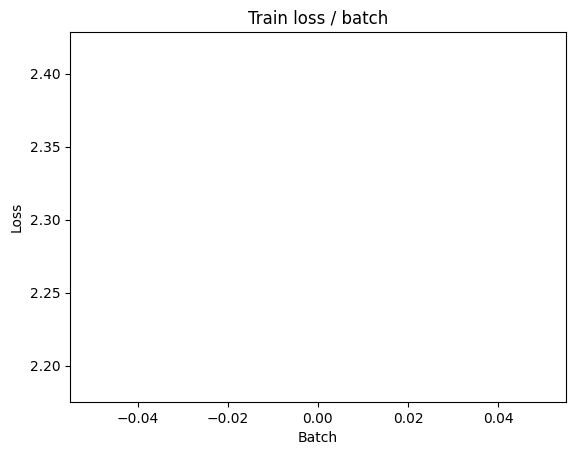

[TRAIN Batch 200/469]	Time 0.004s (0.039s)	Loss 0.3940 (1.1067)	Prec@1  90.6 ( 70.6)	Prec@5  99.2 ( 93.7)


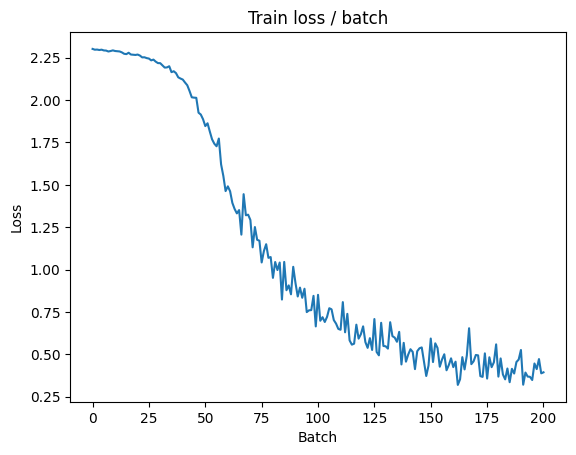

[TRAIN Batch 400/469]	Time 0.059s (0.033s)	Loss 0.4190 (0.6928)	Prec@1  83.6 ( 81.3)	Prec@5 100.0 ( 96.7)


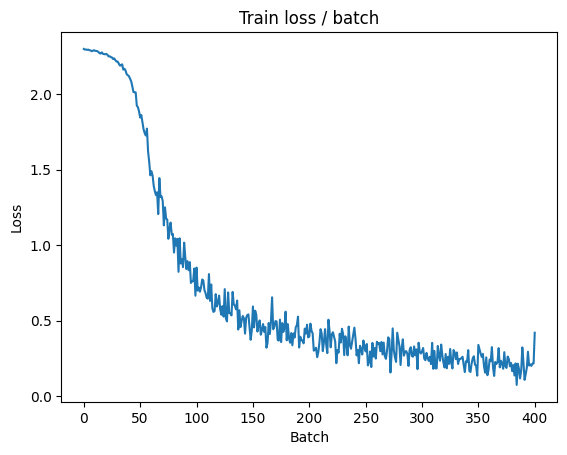


===============> Total time 15s	Avg loss 0.6196	Avg Prec@1 83.21 %	Avg Prec@5 97.12 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 0.1012 (0.1012)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)

===============> Total time 2s	Avg loss 0.1681	Avg Prec@1 94.88 %	Avg Prec@5 99.92 %



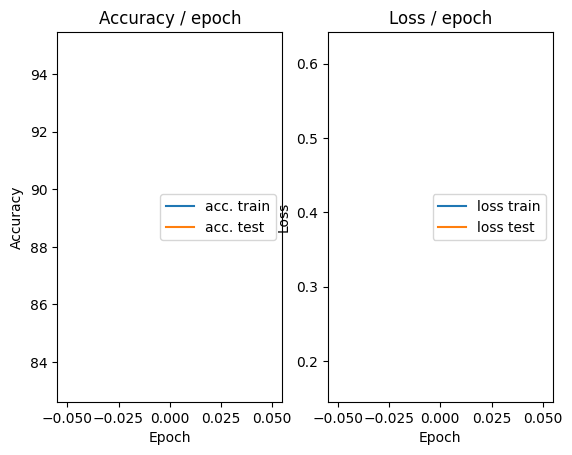

=== EPOCH 2 =====

[TRAIN Batch 000/469]	Time 0.200s (0.200s)	Loss 0.2093 (0.2093)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


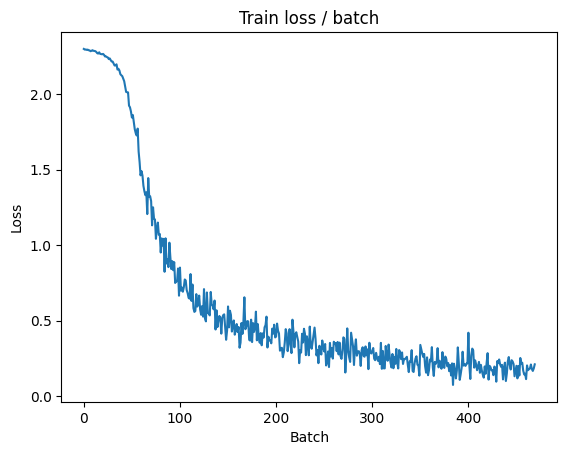

[TRAIN Batch 200/469]	Time 0.007s (0.026s)	Loss 0.1966 (0.1506)	Prec@1  94.5 ( 95.6)	Prec@5 100.0 ( 99.9)


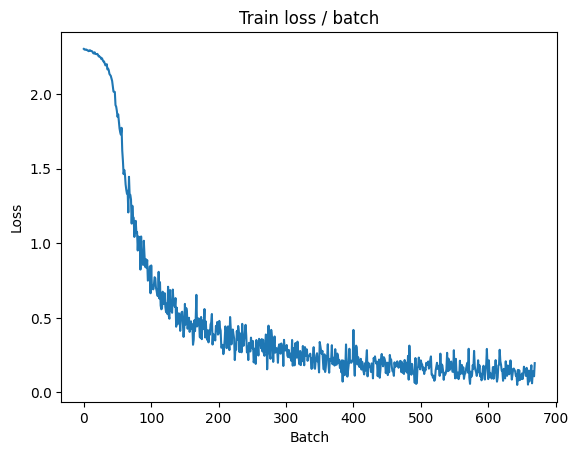

[TRAIN Batch 400/469]	Time 0.003s (0.023s)	Loss 0.1333 (0.1345)	Prec@1  95.3 ( 96.0)	Prec@5 100.0 ( 99.9)


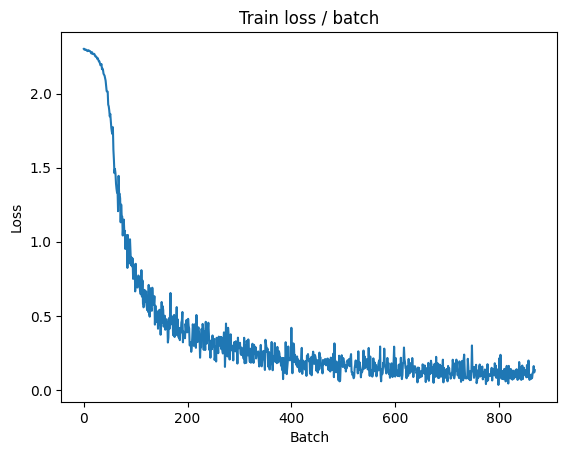


===============> Total time 10s	Avg loss 0.1303	Avg Prec@1 96.13 %	Avg Prec@5 99.89 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 0.0424 (0.0424)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0842	Avg Prec@1 97.50 %	Avg Prec@5 99.97 %



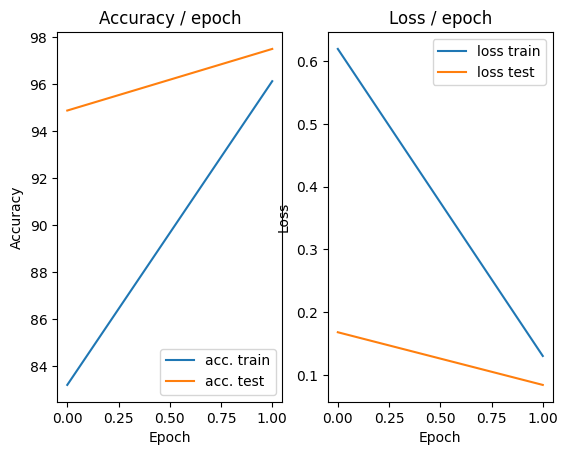

=== EPOCH 3 =====

[TRAIN Batch 000/469]	Time 0.169s (0.169s)	Loss 0.0507 (0.0507)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


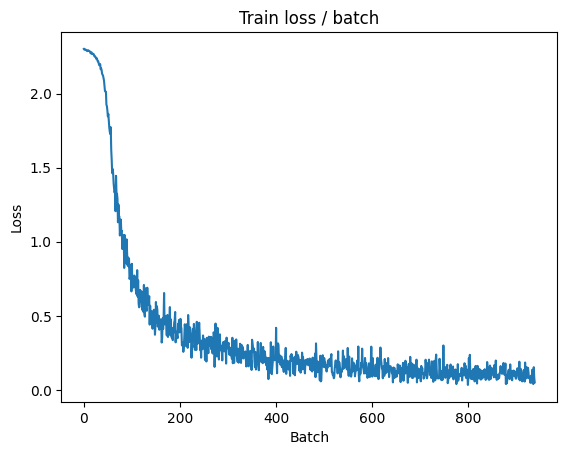

[TRAIN Batch 200/469]	Time 0.003s (0.017s)	Loss 0.0831 (0.0890)	Prec@1  96.1 ( 97.3)	Prec@5 100.0 (100.0)


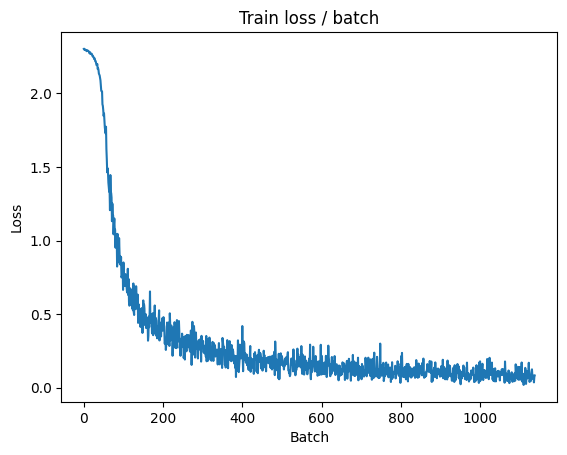

[TRAIN Batch 400/469]	Time 0.016s (0.016s)	Loss 0.0441 (0.0848)	Prec@1  98.4 ( 97.4)	Prec@5 100.0 (100.0)


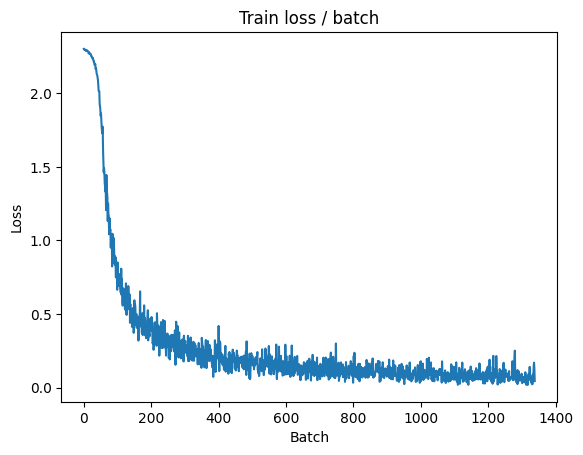


===============> Total time 7s	Avg loss 0.0843	Avg Prec@1 97.46 %	Avg Prec@5 99.95 %

[EVAL Batch 000/079]	Time 0.101s (0.101s)	Loss 0.0430 (0.0430)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0823	Avg Prec@1 97.36 %	Avg Prec@5 100.00 %



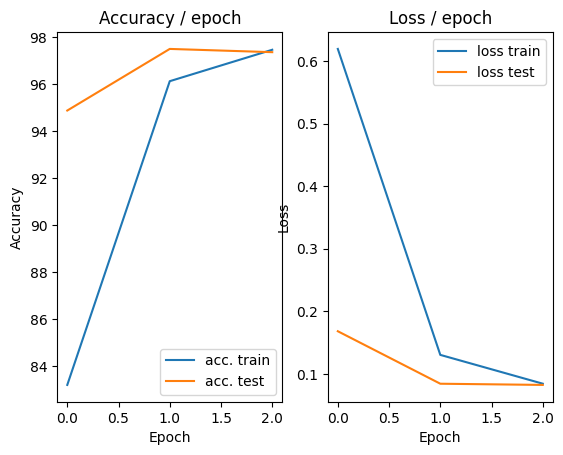

=== EPOCH 4 =====

[TRAIN Batch 000/469]	Time 0.120s (0.120s)	Loss 0.1536 (0.1536)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


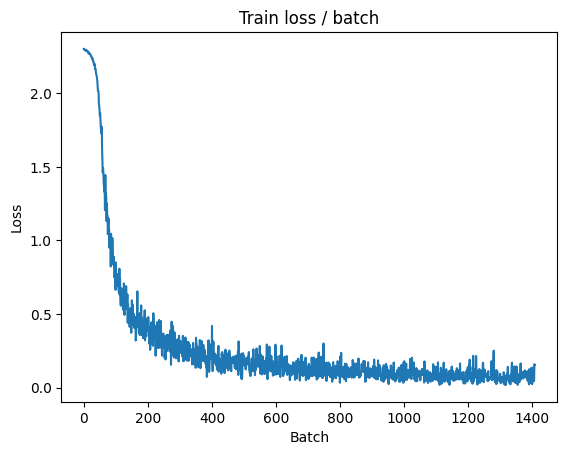

[TRAIN Batch 200/469]	Time 0.027s (0.021s)	Loss 0.0765 (0.0678)	Prec@1  99.2 ( 98.0)	Prec@5 100.0 (100.0)


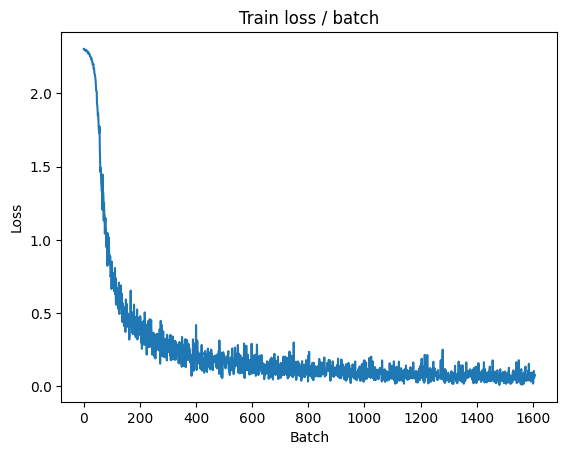

[TRAIN Batch 400/469]	Time 0.008s (0.019s)	Loss 0.0357 (0.0656)	Prec@1  99.2 ( 98.1)	Prec@5 100.0 (100.0)


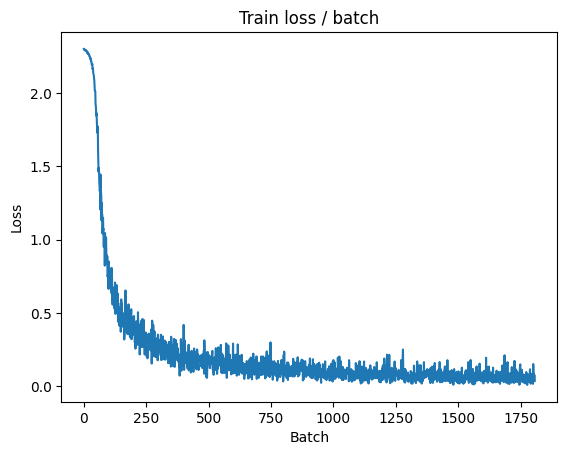


===============> Total time 8s	Avg loss 0.0651	Avg Prec@1 98.07 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.094s (0.094s)	Loss 0.0272 (0.0272)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0486	Avg Prec@1 98.50 %	Avg Prec@5 100.00 %



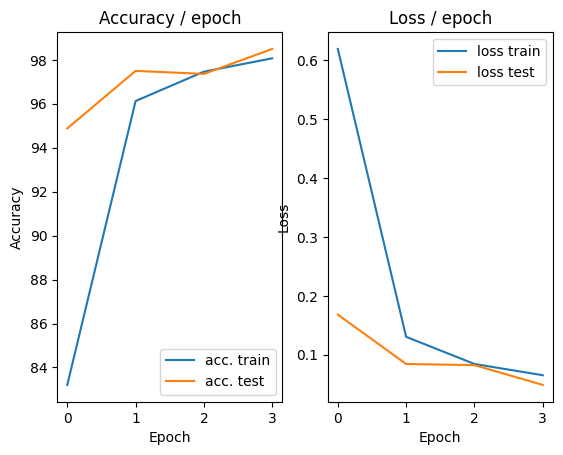

=== EPOCH 5 =====

[TRAIN Batch 000/469]	Time 0.127s (0.127s)	Loss 0.0645 (0.0645)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


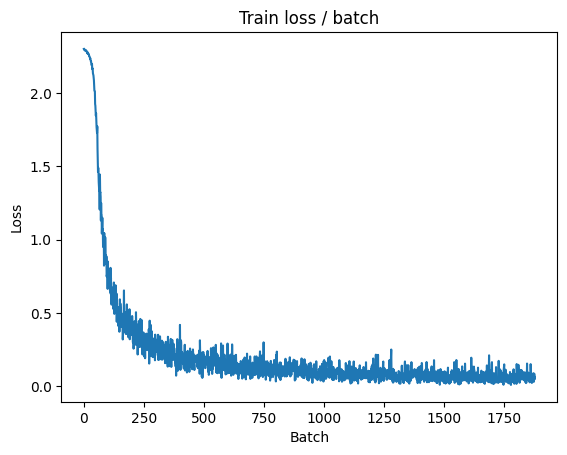

[TRAIN Batch 200/469]	Time 0.003s (0.016s)	Loss 0.0269 (0.0556)	Prec@1 100.0 ( 98.3)	Prec@5 100.0 (100.0)


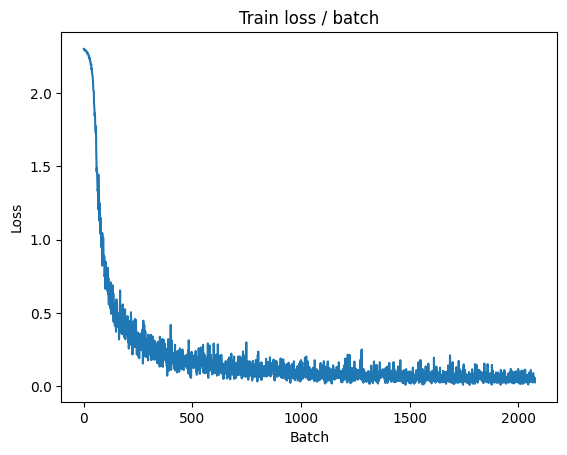

[TRAIN Batch 400/469]	Time 0.027s (0.018s)	Loss 0.0260 (0.0531)	Prec@1  99.2 ( 98.4)	Prec@5 100.0 (100.0)


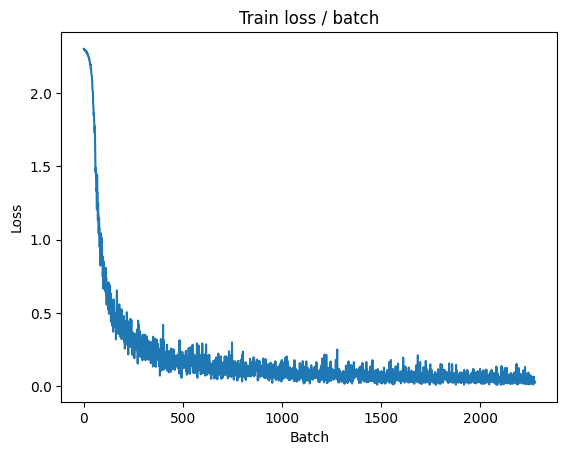


===============> Total time 8s	Avg loss 0.0535	Avg Prec@1 98.38 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 0.0191 (0.0191)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0581	Avg Prec@1 98.16 %	Avg Prec@5 99.98 %



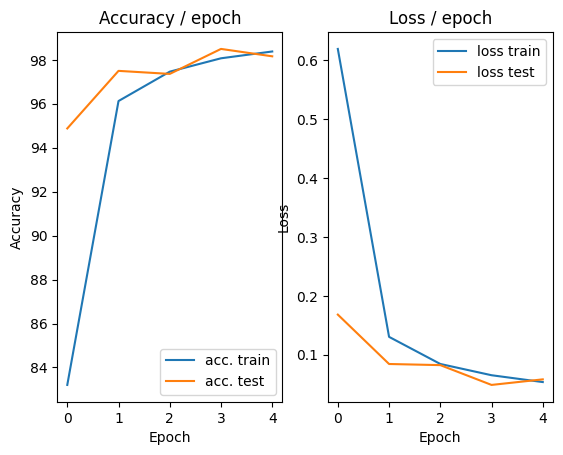

In [ ]:
main(128, 0.1, cuda=True)

# CIFAR-10 Dataset

## Training from Scratch the model

Files already downloaded and verified
Files already downloaded and verified


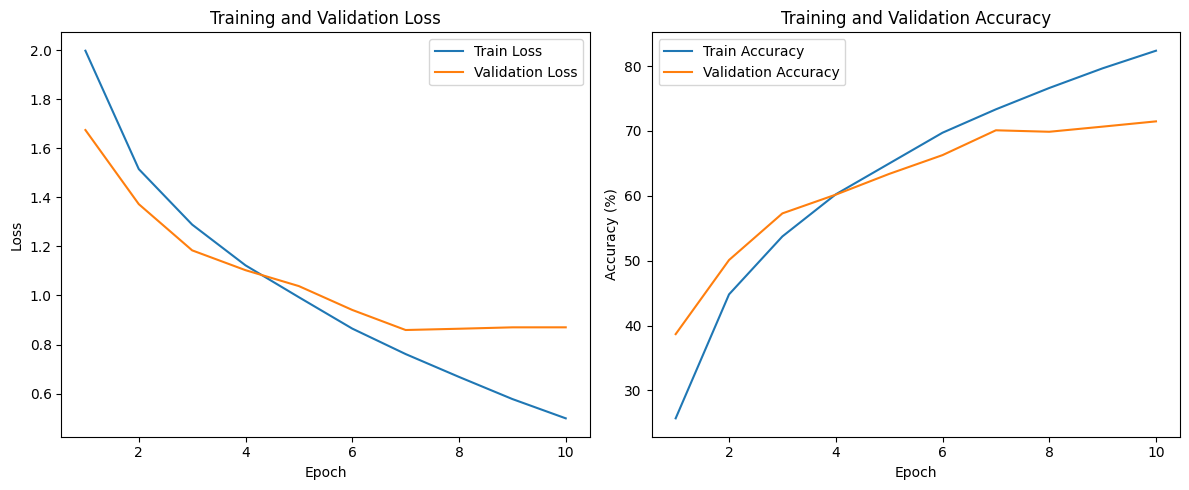

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define the ConvNet class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)
        output = self.classifier(output)
        return output


def get_dataset(batch_size, cuda=False):
    transform = transforms.Compose([
        transforms.ToTensor()
        # ,
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)


    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        # print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


if __name__ == '__main__':
    main(batch_size=128, lr=0.01, epochs=10, cuda=torch.cuda.is_available())


## Influence of **Batch size** and **Learning rate**

### **Learning Rate** variation with fixed **BATCH_SIZE**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define the ConvNet class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)
        output = self.classifier(output)
        return output


def get_dataset(batch_size, cuda=False):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1 = accuracy(output, target)
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())

    return avg_top1_acc.avg, avg_loss.avg


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res[0]  # Return top-1 accuracy


# Main function to train and validate the model
def main(batch_size=128, lr=0.1, epochs=5, cuda=False):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        # Train phase
        train_acc, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


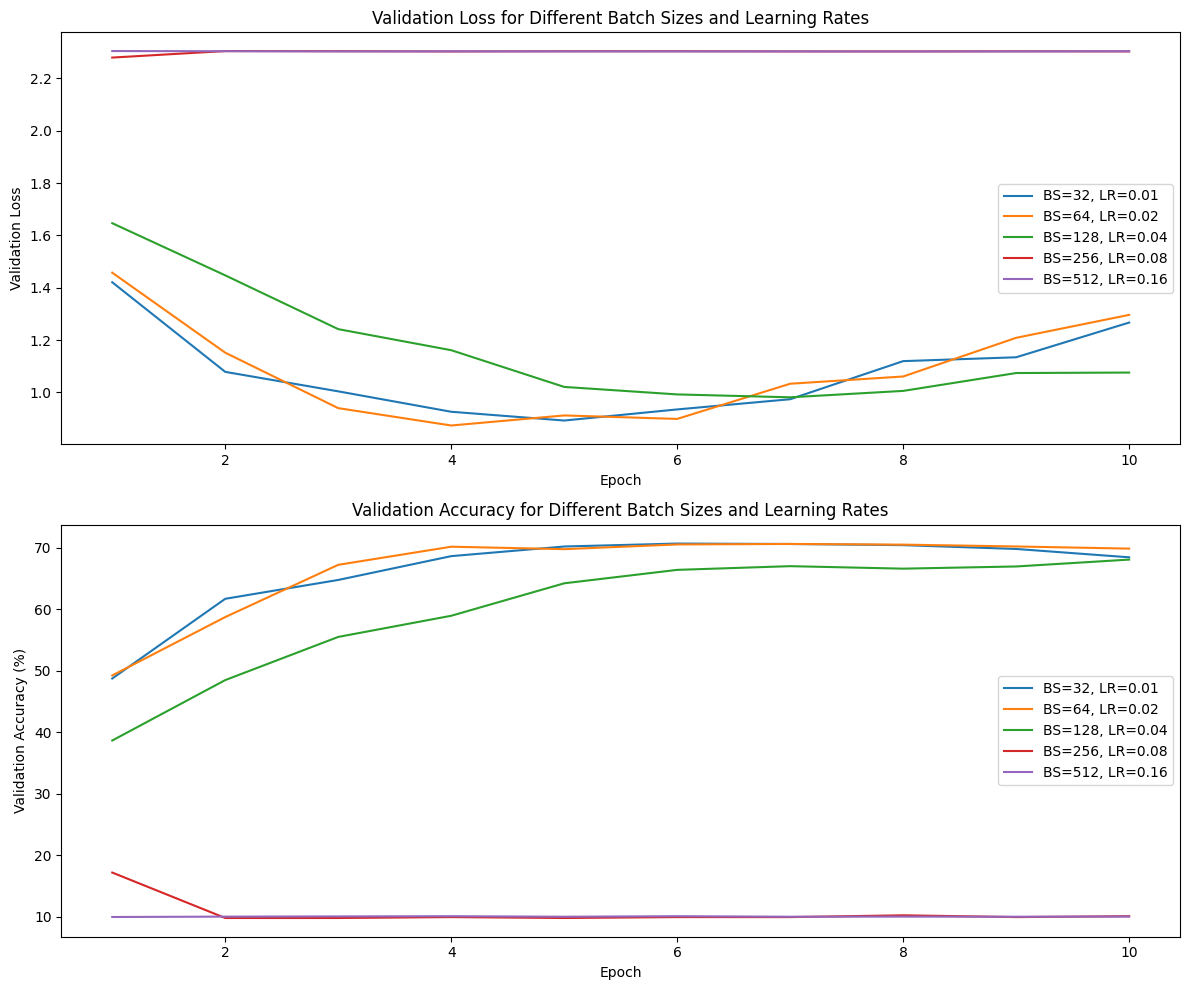

In [ ]:


# Hyperparameters and setup for different configurations
BATCH_SIZE = 32
LR = 0.01
EPOCHS = 10
CUDA = torch.cuda.is_available()

# Store results of different configurations for plotting
results = []

# Run with different learning rate and batch size scaling
for scale in range(5):
    scaled_batch_size = BATCH_SIZE * (2 ** scale)
    scaled_lr = LR * (2 ** scale)
    train_losses, val_losses, train_accs, val_accs = main(scaled_batch_size, scaled_lr, epochs=EPOCHS, cuda=CUDA)
    results.append({
        'batch_size': scaled_batch_size,
        'learning_rate': scaled_lr,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })

# Plotting the losses and accuracies for comparison
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 10))

# Loss plot
plt.subplot(2, 1, 1)
for result in results:
    plt.plot(epochs_range, result['val_losses'], label=f'BS={result["batch_size"]}, LR={result["learning_rate"]}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Batch Sizes and Learning Rates')
plt.legend()

# Accuracy plot
plt.subplot(2, 1, 2)
for result in results:
    plt.plot(epochs_range, result['val_accs'], label=f'BS={result["batch_size"]}, LR={result["learning_rate"]}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy for Different Batch Sizes and Learning Rates')
plt.legend()

plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified


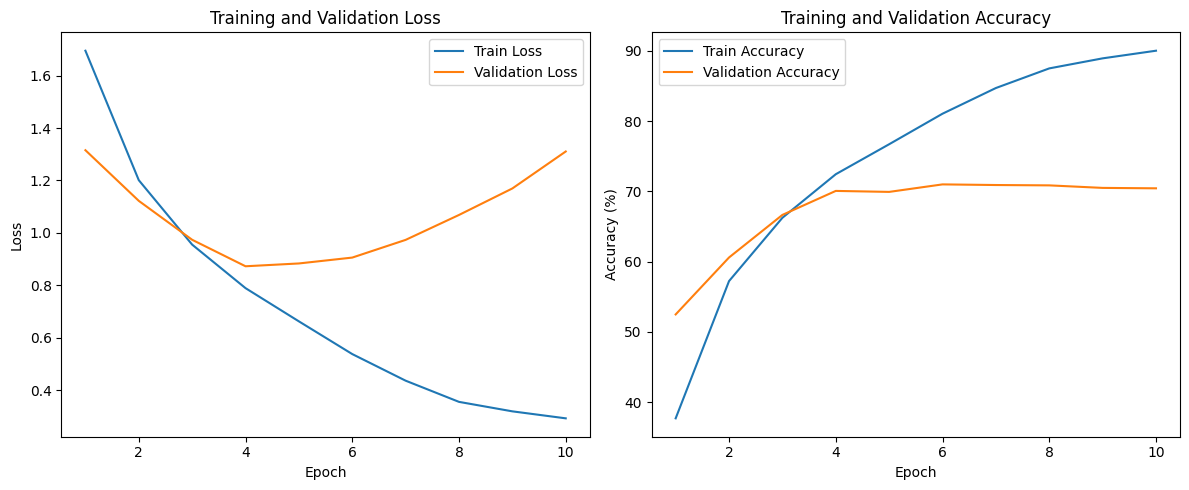

Files already downloaded and verified
Files already downloaded and verified


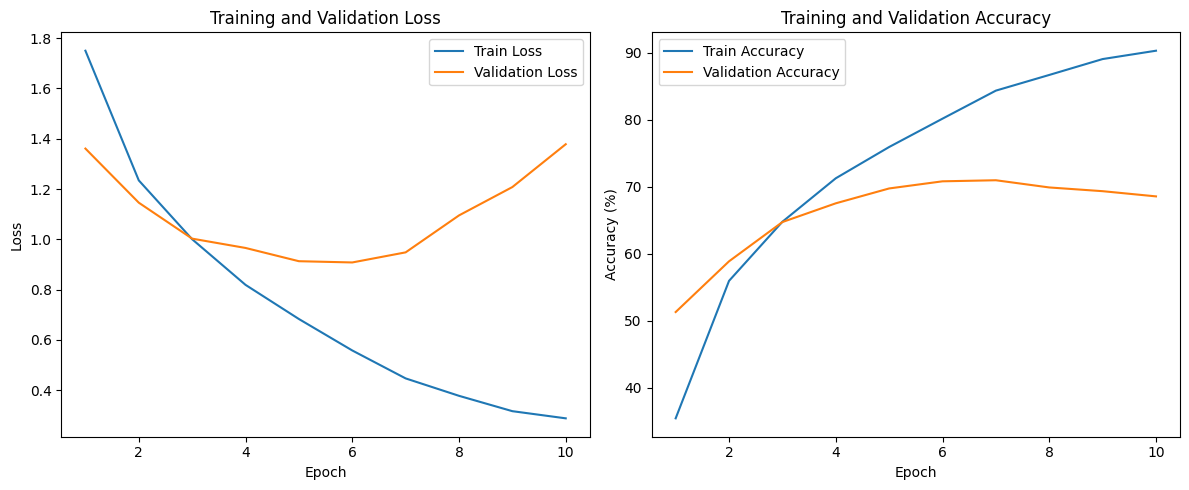

Files already downloaded and verified
Files already downloaded and verified


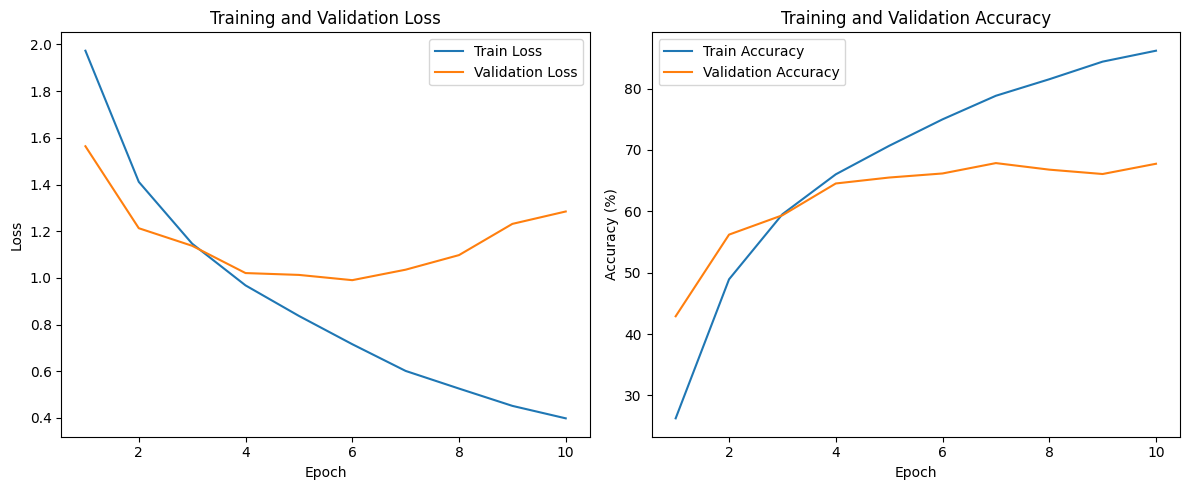

Files already downloaded and verified
Files already downloaded and verified


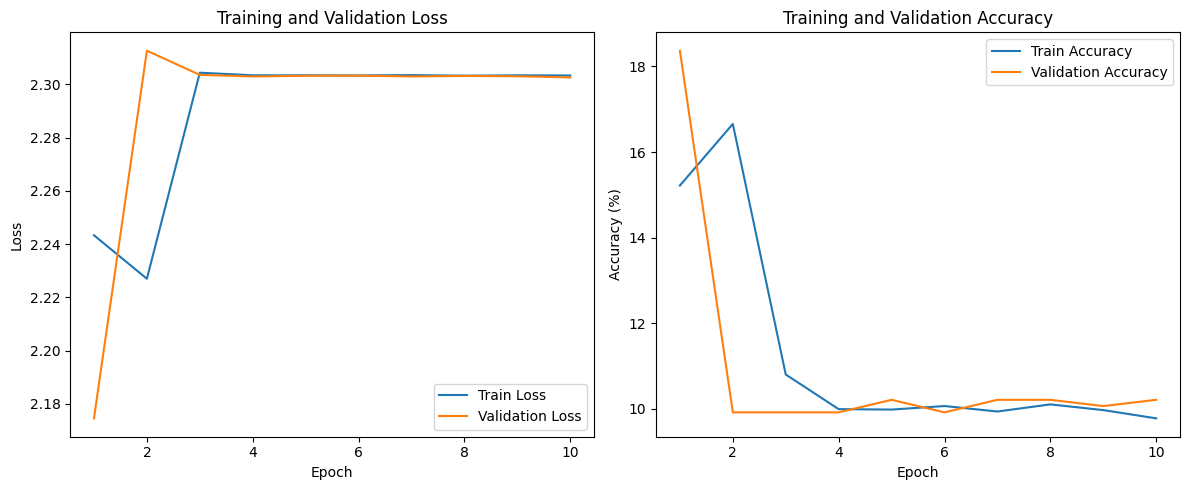

Files already downloaded and verified
Files already downloaded and verified


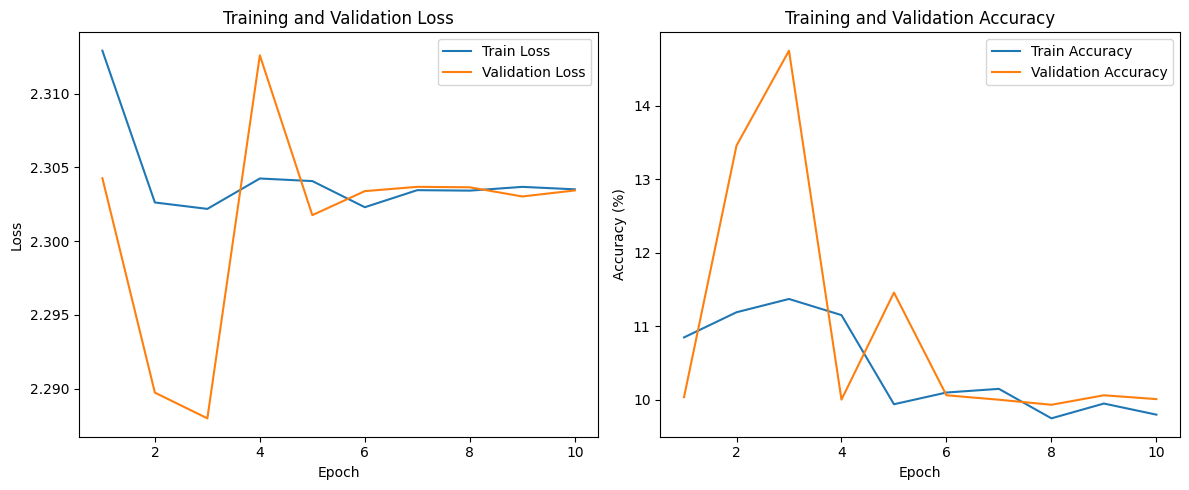

In [ ]:
BATCH_SIZE = 32
LR = 0.01

for lr in [2**n for n in range(5)]:
    main(BATCH_SIZE * lr, LR * lr, epochs=10, cuda=torch.cuda.is_available())

In [ ]:
main(batch_size=128, lr=0.005, epochs=10, cuda=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


### **BATCH_SIZE** variation with fixed **Learning Rate**

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


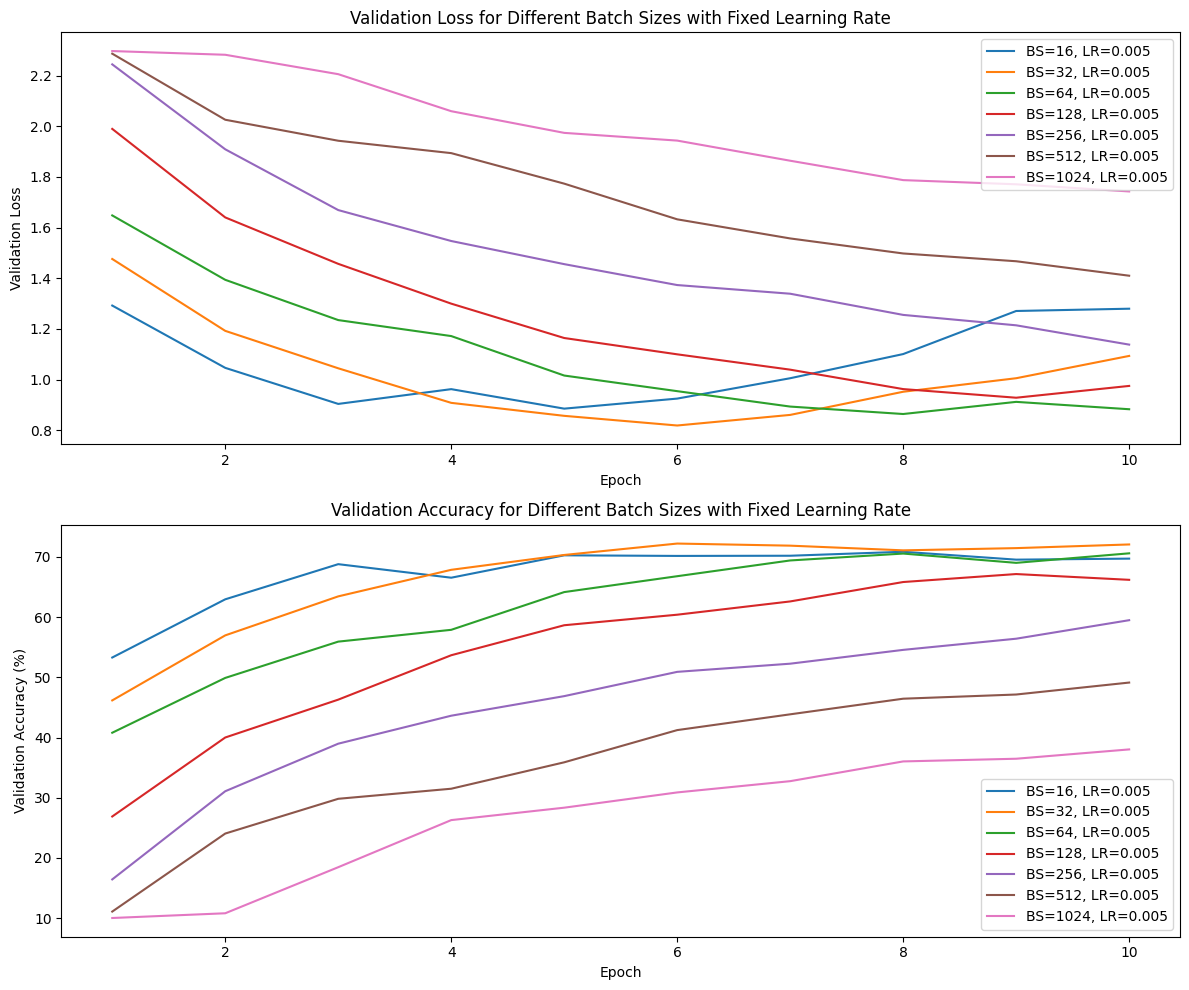

In [ ]:
# Hyperparameters and setup for different configurations
LEARNING_RATE = 0.005  # Fixed learning rate
EPOCHS = 10
CUDA = torch.cuda.is_available()

# Store results of different configurations for plotting
results = []

# Run with varying batch sizes and fixed learning rate
for scale in range(4, 11):  # Adjust range for desired batch size range
    batch_size = 2 ** scale  # Varying batch sizes
    train_losses, val_losses, train_accs, val_accs = main(batch_size, LEARNING_RATE, epochs=EPOCHS, cuda=CUDA)
    results.append({
        'batch_size': batch_size,
        'learning_rate': LEARNING_RATE,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    })

# Plotting the losses and accuracies for comparison
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 10))

# Validation Loss plot
plt.subplot(2, 1, 1)
for result in results:
    plt.plot(epochs_range, result['val_losses'], label=f'BS={result["batch_size"]}, LR={result["learning_rate"]}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Batch Sizes with Fixed Learning Rate')
plt.legend()

# Validation Accuracy plot
plt.subplot(2, 1, 2)
for result in results:
    plt.plot(epochs_range, result['val_accs'], label=f'BS={result["batch_size"]}, LR={result["learning_rate"]}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy for Different Batch Sizes with Fixed Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()


Files already downloaded and verified
Files already downloaded and verified


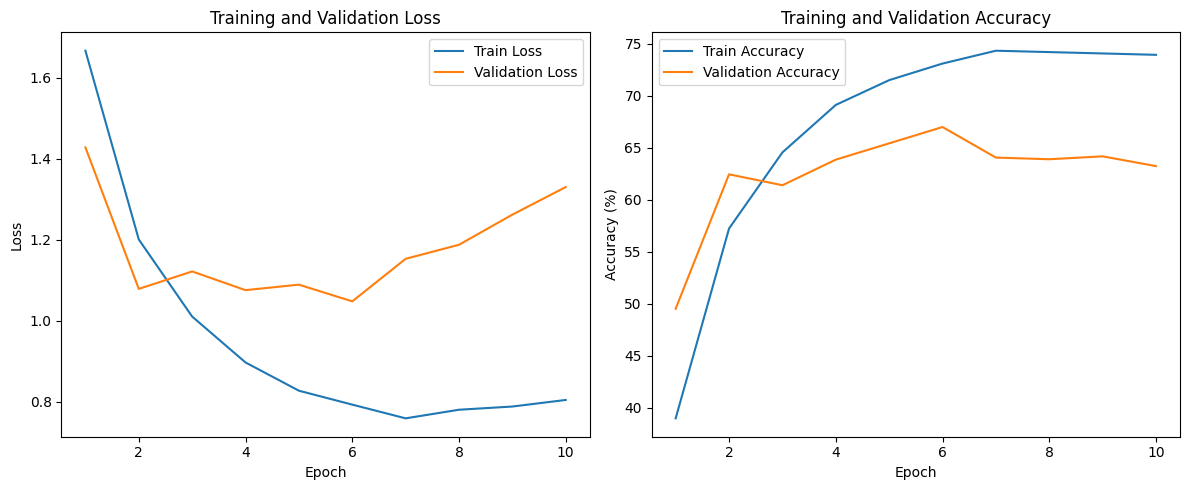

Files already downloaded and verified
Files already downloaded and verified


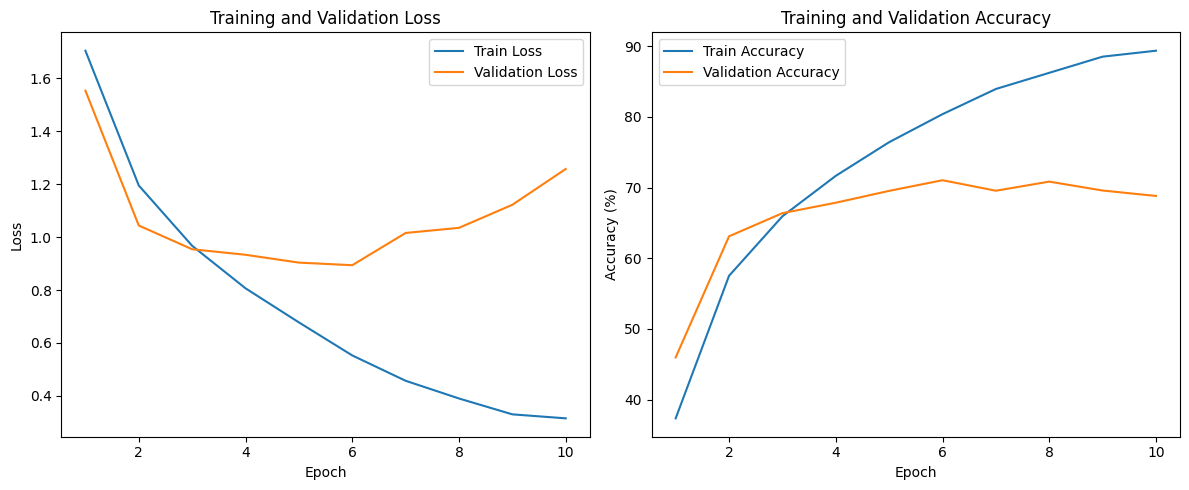

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for batch_size in [2**n for n in range(4, 11)]:
    main(batch_size, LR, epochs=10, cuda=torch.cuda.is_available())

# Results Improvements

## Standarization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define the ConvNet class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)
        output = self.classifier(output)
        return output


def get_dataset(batch_size, cuda=False):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)

    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        # print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


if __name__ == '__main__':
    main(batch_size=128, lr=0.005, epochs=10, cuda=torch.cuda.is_available())


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)
        output = self.classifier(output)
        return output


# Normalization methods
def per_channel_standardization(image):
    mean = torch.tensor([0.491, 0.482, 0.447]).view(3, 1, 1)
    std = torch.tensor([0.202, 0.199, 0.201]).view(3, 1, 1)
    return (image - mean) / std

def zca_whitening(image, epsilon=1e-5):
    image = image.view(3, -1).numpy()
    sigma = np.cov(image, rowvar=True)
    U, S, _ = np.linalg.svd(sigma + epsilon * np.eye(sigma.shape[0]))
    ZCA_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S)), U.T))
    whitened = np.dot(ZCA_matrix, image)
    return torch.tensor(whitened).view(3, 32, 32)

def min_max_normalization(image, min_val=0, max_val=1):
    min_image = image.min()
    max_image = image.max()
    return (image - min_image) / (max_image - min_image) * (max_val - min_val) + min_val


def get_dataset(batch_size, cuda=False, method='standardization'):
    # Define transform functions based on the selected normalization method
    if method == 'standardization':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: per_channel_standardization(x))
        ])
    elif method == 'zca':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: zca_whitening(x))
        ])
    elif method == 'min_max':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: min_max_normalization(x))
        ])
    else:
        raise ValueError(f"Unknown method: {method}")

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)

    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False, method='standardization'):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda, method=method)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        # print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res



Files already downloaded and verified
Files already downloaded and verified


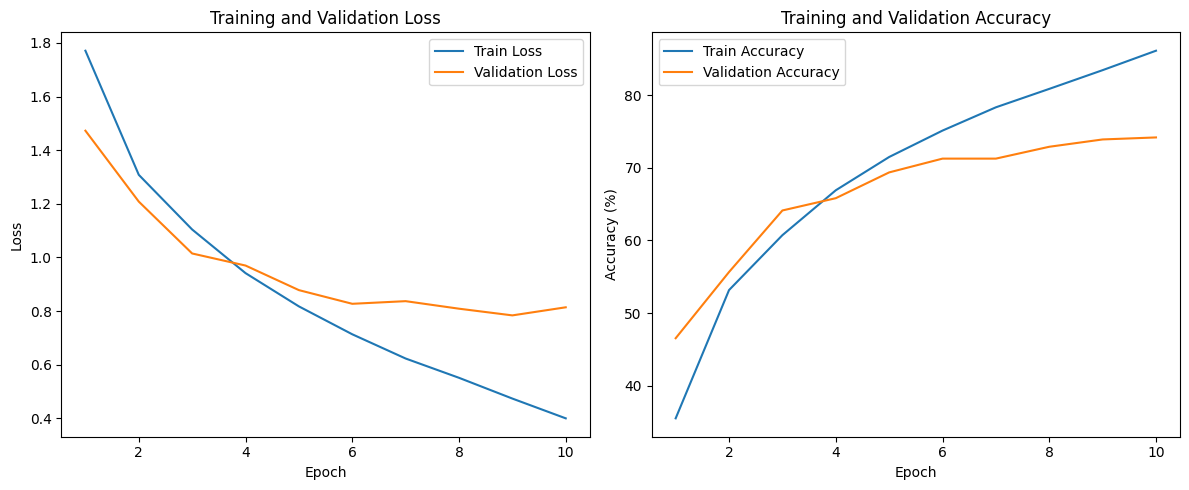

Files already downloaded and verified
Files already downloaded and verified


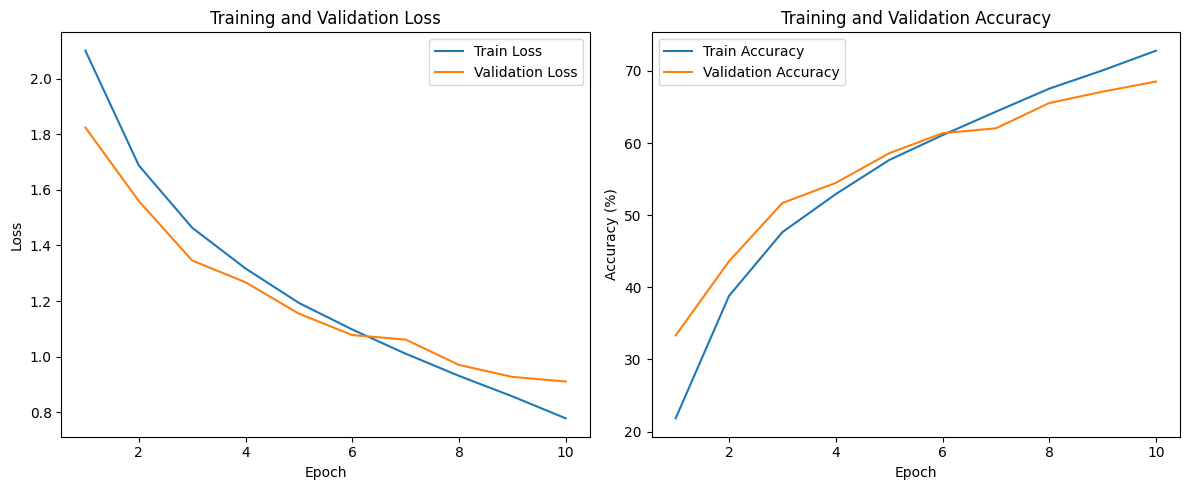

In [ ]:
standarizations = ['standardization','min_max']
for method in standarizations:
    main(batch_size=128, lr=0.005, epochs=10, cuda=torch.cuda.is_available(), method=method)


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 ====

TRAIN Batch 0/391	Time 0.719s (0.719s)	Loss 2.3390 (2.3390)	Prec@1   8.6 (  8.6)	Prec@5  50.8 ( 50.8)
TRAIN Batch 10/391	Time 0.012s (0.094s)	Loss 2.3539 (2.3398)	Prec@1  14.8 ( 13.2)	Prec@5  58.6 ( 52.6)
TRAIN Batch 20/391	Time 0.075s (0.071s)	Loss 2.1742 (2.2949)	Prec@1  20.3 ( 14.6)	Prec@5  64.8 ( 57.4)
TRAIN Batch 30/391	Time 0.077s (0.065s)	Loss 2.0696 (2.2428)	Prec@1  19.5 ( 15.7)	Prec@5  73.4 ( 62.0)
TRAIN Batch 40/391	Time 0.026s (0.060s)	Loss 2.0398 (2.2006)	Prec@1  22.7 ( 17.3)	Prec@5  76.6 ( 65.6)
TRAIN Batch 50/391	Time 0.032s (0.054s)	Loss 1.9380 (2.1630)	Prec@1  24.2 ( 19.0)	Prec@5  82.0 ( 68.2)
TRAIN Batch 60/391	Time 0.035s (0.049s)	Loss 2.0708 (2.1246)	Prec@1  20.3 ( 20.7)	Prec@5  75.8 ( 70.6)
TRAIN Batch 70/391	Time 0.043s (0.046s)	Loss 1.8457 (2.0888)	Prec@1  27.3 ( 21.8)	Prec@5  86.7 ( 72.6)
TRAIN Batch 80/391	Time 0.044s (0.044s)	Loss 1.8236 (2.0605)	Prec@1  30.5 ( 23.0)	P

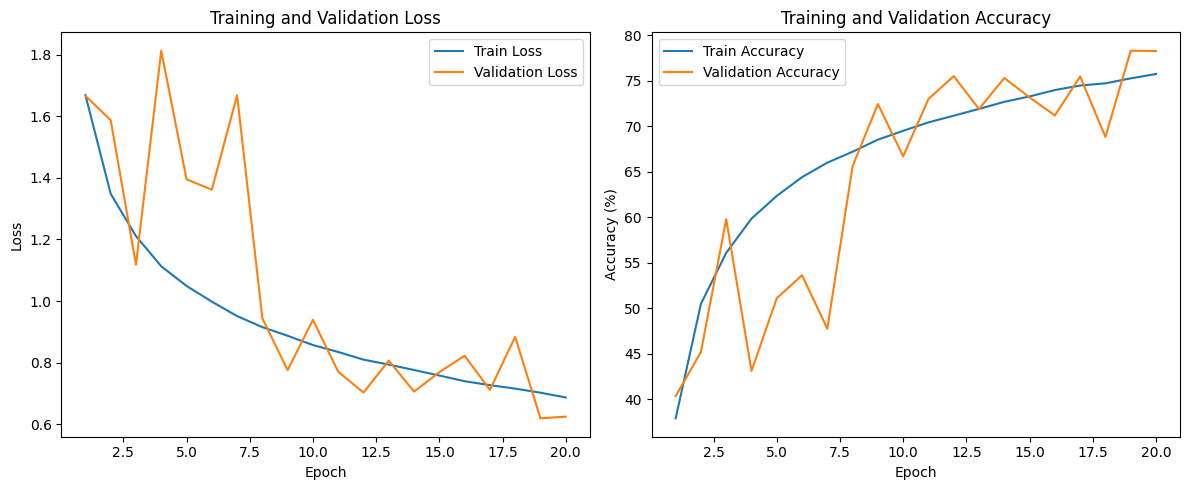

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class with Dropout layers
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class with Dropout layers
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Smaller kernel size
            nn.BatchNorm2d(32),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Increased number of filters
            nn.BatchNorm2d(128),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Additional convolutional layer
            nn.BatchNorm2d(128),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # The correct flattened size is 128 * 2 * 2 = 512, based on the output from the conv layers.
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1000),  # Updated input size of the first linear layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Added Dropout before the final layer
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)  # Flatten the conv layer output
        output = self.classifier(output)
        return output


# The rest of your code remains unchanged...



# Normalization methods
def per_channel_standardization(image):
    mean = torch.tensor([0.491, 0.482, 0.447]).view(3, 1, 1)
    std = torch.tensor([0.202, 0.199, 0.201]).view(3, 1, 1)
    return (image - mean) / std

def zca_whitening(image, epsilon=1e-5):
    image = image.view(3, -1).numpy()
    sigma = np.cov(image, rowvar=True)
    U, S, _ = np.linalg.svd(sigma + epsilon * np.eye(sigma.shape[0]))
    ZCA_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S)), U.T))
    whitened = np.dot(ZCA_matrix, image)
    return torch.tensor(whitened).view(3, 32, 32)

def min_max_normalization(image, min_val=0, max_val=1):
    min_image = image.min()
    max_image = image.max()
    return (image - min_image) / (max_image - min_image) * (max_val - min_val) + min_val


def get_dataset(batch_size, cuda=False, method='standardization'):
    # Define transform functions based on the selected normalization method
    if method == 'standardization':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: per_channel_standardization(x))
        ])
    elif method == 'zca':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: zca_whitening(x))
        ])
    elif method == 'min_max':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: min_max_normalization(x))
        ])
    else:
        raise ValueError(f"Unknown method: {method}")

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)

        if i % 10 == 0:
            print(f'{"EVAL" if optimizer is None else "TRAIN"} Batch {i}/{len(data)}\t'
                  f'Time {avg_batch_time.val:.3f}s ({avg_batch_time.avg:.3f}s)\t'
                  f'Loss {avg_loss.val:.4f} ({avg_loss.avg:.4f})\t'
                  f'Prec@1 {avg_top1_acc.val:5.1f} ({avg_top1_acc.avg:5.1f})\t'
                  f'Prec@5 {avg_top5_acc.val:5.1f} ({avg_top5_acc.avg:5.1f})')

    print(f'\nTotal time {int(avg_batch_time.sum)}s\t'
          f'Avg loss {avg_loss.avg:.4f}\t'
          f'Avg Prec@1 {avg_top1_acc.avg:.2f}%\t'
          f'Avg Prec@5 {avg_top5_acc.avg:.2f}%\n')

    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False, method='standardization'):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda, method=method)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


if __name__ == '__main__':
    main(batch_size=128, lr=0.005, epochs=20, cuda=torch.cuda.is_available(), method='min_max')


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 ====

TRAIN Batch 0/391	Time 0.174s (0.174s)	Loss 2.4661 (2.4661)	Prec@1   7.8 (  7.8)	Prec@5  47.7 ( 47.7)
TRAIN Batch 10/391	Time 0.041s (0.039s)	Loss 2.2663 (2.3597)	Prec@1  17.2 ( 11.0)	Prec@5  57.0 ( 52.8)
TRAIN Batch 20/391	Time 0.041s (0.034s)	Loss 2.1483 (2.2833)	Prec@1  21.9 ( 14.5)	Prec@5  68.8 ( 59.1)
TRAIN Batch 30/391	Time 0.030s (0.031s)	Loss 1.9511 (2.2126)	Prec@1  24.2 ( 17.3)	Prec@5  81.2 ( 64.5)
TRAIN Batch 40/391	Time 0.061s (0.034s)	Loss 2.0293 (2.1739)	Prec@1  25.8 ( 18.8)	Prec@5  82.8 ( 67.7)
TRAIN Batch 50/391	Time 0.020s (0.037s)	Loss 2.0872 (2.1449)	Prec@1  22.7 ( 19.9)	Prec@5  74.2 ( 70.2)
TRAIN Batch 60/391	Time 0.021s (0.036s)	Loss 1.9366 (2.1104)	Prec@1  26.6 ( 21.0)	Prec@5  85.9 ( 72.2)
TRAIN Batch 70/391	Time 0.015s (0.035s)	Loss 1.8466 (2.0786)	Prec@1  32.0 ( 22.4)	Prec@5  82.8 ( 73.6)
TRAIN Batch 80/391	Time 0.030s (0.034s)	Loss 1.8014 (2.0439)	Prec@1  28.1 ( 23.5)	P

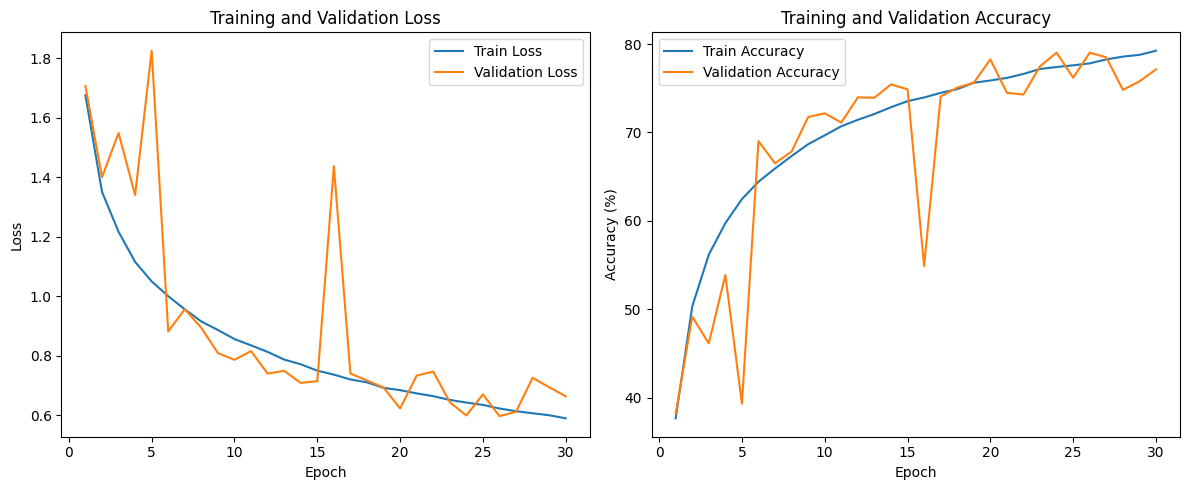

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class with Dropout layers
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class with Dropout layers
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Smaller kernel size
            nn.BatchNorm2d(32),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Increased number of filters
            nn.BatchNorm2d(128),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Additional convolutional layer
            nn.BatchNorm2d(128),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # The correct flattened size is 128 * 2 * 2 = 512, based on the output from the conv layers.
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1000),  # Updated input size of the first linear layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Added Dropout before the final layer
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)  # Flatten the conv layer output
        output = self.classifier(output)
        return output


# The rest of your code remains unchanged...



# Normalization methods
def per_channel_standardization(image):
    mean = torch.tensor([0.491, 0.482, 0.447]).view(3, 1, 1)
    std = torch.tensor([0.202, 0.199, 0.201]).view(3, 1, 1)
    return (image - mean) / std

def zca_whitening(image, epsilon=1e-5):
    image = image.view(3, -1).numpy()
    sigma = np.cov(image, rowvar=True)
    U, S, _ = np.linalg.svd(sigma + epsilon * np.eye(sigma.shape[0]))
    ZCA_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S)), U.T))
    whitened = np.dot(ZCA_matrix, image)
    return torch.tensor(whitened).view(3, 32, 32)

def min_max_normalization(image, min_val=0, max_val=1):
    min_image = image.min()
    max_image = image.max()
    return (image - min_image) / (max_image - min_image) * (max_val - min_val) + min_val


def get_dataset(batch_size, cuda=False, method='standardization'):
    # Define transform functions based on the selected normalization method
    if method == 'standardization':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: per_channel_standardization(x))
        ])
    elif method == 'zca':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: zca_whitening(x))
        ])
    elif method == 'min_max':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: min_max_normalization(x))
        ])
    else:
        raise ValueError(f"Unknown method: {method}")

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)

        if i % 10 == 0:
            print(f'{"EVAL" if optimizer is None else "TRAIN"} Batch {i}/{len(data)}\t'
                  f'Time {avg_batch_time.val:.3f}s ({avg_batch_time.avg:.3f}s)\t'
                  f'Loss {avg_loss.val:.4f} ({avg_loss.avg:.4f})\t'
                  f'Prec@1 {avg_top1_acc.val:5.1f} ({avg_top1_acc.avg:5.1f})\t'
                  f'Prec@5 {avg_top5_acc.val:5.1f} ({avg_top5_acc.avg:5.1f})')

    print(f'\nTotal time {int(avg_batch_time.sum)}s\t'
          f'Avg loss {avg_loss.avg:.4f}\t'
          f'Avg Prec@1 {avg_top1_acc.avg:.2f}%\t'
          f'Avg Prec@5 {avg_top5_acc.avg:.2f}%\n')

    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False, method='standardization'):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda, method=method)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


if __name__ == '__main__':
    main(batch_size=128, lr=0.005, epochs=30, cuda=torch.cuda.is_available(), method='min_max')


## Dropout

### Without Dropouts

In [ ]:
# Define the ConvNet class with Dropout layers
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Smaller kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Increased number of filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Additional convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # The correct flattened size is 128 * 2 * 2 = 512, based on the output from the conv layers.
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1000),  # Updated input size of the first linear layer
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)  # Flatten the conv layer output
        output = self.classifier(output)
        return output


# The rest of your code remains unchanged...



def get_dataset(batch_size, cuda=False):
    # Define transform functions based on the selected normalization method
    transform = transforms.Compose([
    transforms.ToTensor()])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)

    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        # print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Files already downloaded and verified
Files already downloaded and verified


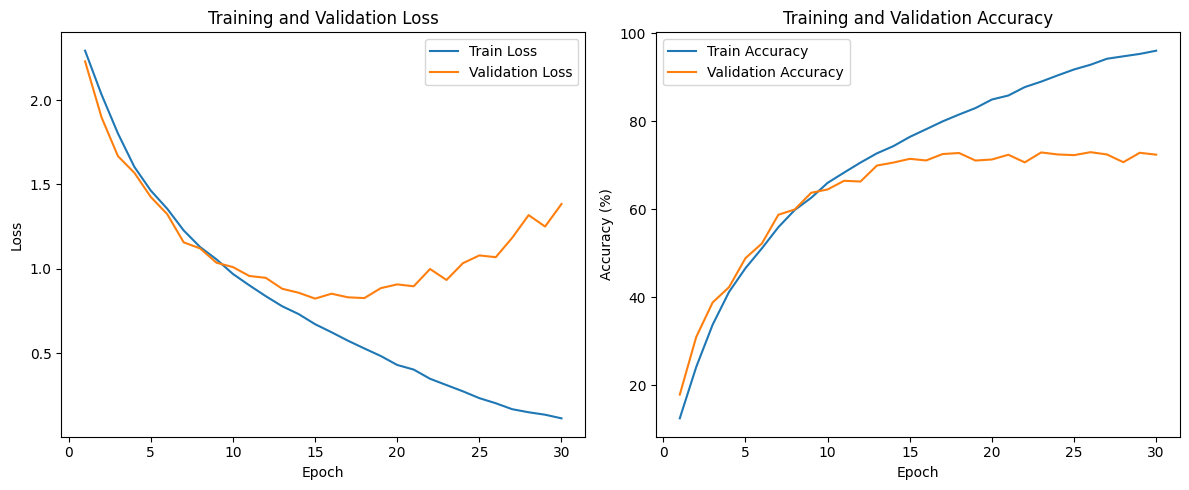

In [ ]:
main(batch_size=128, lr=0.005, epochs=30, cuda=torch.cuda.is_available())

### With Dropouts

## Data Augmentation


In [ ]:
# Define the ConvNet class with Dropout layers
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Smaller kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Increased number of filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Additional convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # The correct flattened size is 128 * 2 * 2 = 512, based on the output from the conv layers.
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1000),  # Updated input size of the first linear layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Added Dropout before the final layer
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)  # Flatten the conv layer output
        output = self.classifier(output)
        return output




def get_dataset(batch_size, cuda=False):

    transform = transforms.Compose([
    transforms.ToTensor()])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)

    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        # print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Files already downloaded and verified
Files already downloaded and verified


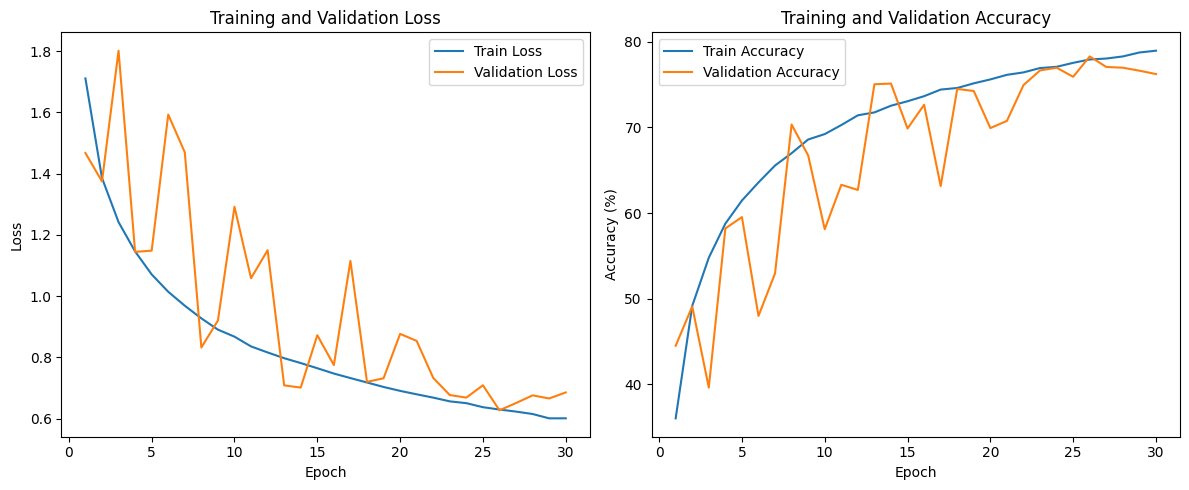

In [ ]:
main(batch_size=128, lr=0.005, epochs=30, cuda=torch.cuda.is_available())

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)
        output = self.classifier(output)
        return output



def get_dataset(batch_size, cuda=False, transform=None):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    download = False
    if not os.path.isfile(f"{PATH}/cifar-10-python.tar.gz"):
        download = True

    transform_train = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomErasing(),
            transforms.RandomRotation(degrees=(0, 180))
        ]
    )
    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation(degrees=(180, 360))
        ]
    )

    train_dataset = datasets.CIFAR10(
        PATH,
        train=True,
        download=download,
        transform=transform_train
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=download,
        transform=transform_test,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader

def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)

    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        # print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


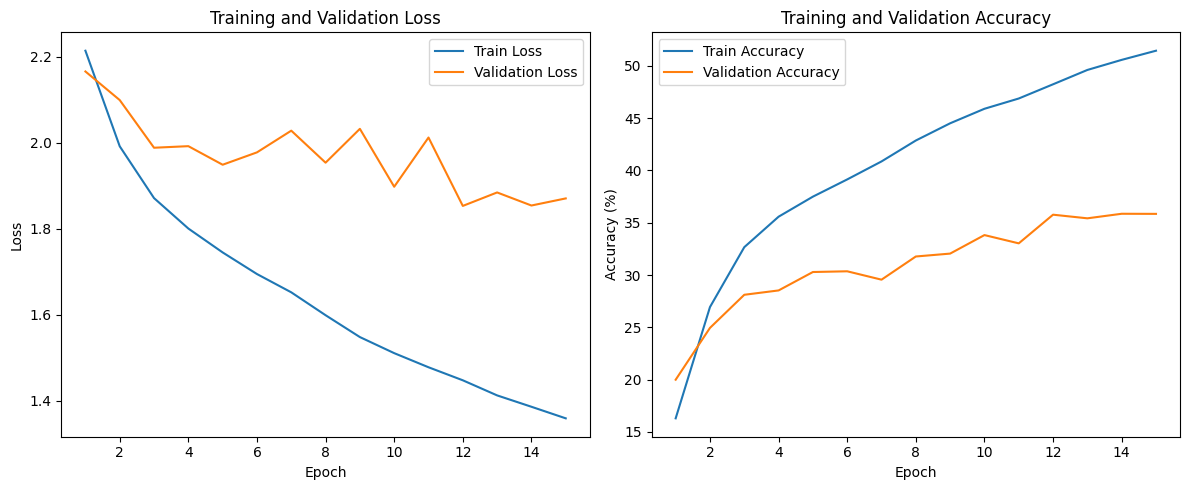

In [ ]:
main(batch_size=128, lr=0.005, epochs=15, cuda=torch.cuda.is_available())

## Variants on the optimization algorithm

In [ ]:
class TrainLossPlot(object):
    def __init__(self):
        self.loss_train = []
        self.fig = plt.figure()

    def update(self, loss_train):
        self.loss_train.append(loss_train)

    def plot(self):
        plt.figure(self.fig.number)
        plt.clf()
        plt.plot(np.array(self.loss_train))
        plt.title("Train loss / batch")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
        plt.draw_all()
        plt.pause(1e-3)


class AccLossPlot(object):
    def __init__(self):
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
        # self.fig = plt.figure()

    def update(self, loss_train, loss_test, acc_train, acc_test):
        self.loss_train.append(loss_train)
        self.loss_test.append(loss_test)
        self.acc_train.append(acc_train)
        self.acc_test.append(acc_test)

    def plot(self, save_name=None):
        plt.figure(figsize=(15, 5))
        # plt.clf()
        plt.subplot(1, 2, 1)
        plt.plot(np.array(self.acc_train), label="acc. train")
        plt.plot(np.array(self.acc_test), label="acc. test")
        plt.title("Accuracy / epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(np.array(self.loss_train), label="loss train")
        plt.plot(np.array(self.loss_test), label="loss test")
        plt.title("Loss / epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        if save_name is not None:
            plt.savefig(f"{save_name}.pdf", dpi=100, bbox_inches="tight")
        plt.show()


In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.notebook import tqdm



class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(bsize, -1)  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output


def get_dataset(batch_size, cuda=False, transform=None):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    download = False
    if not os.path.isfile(f"{PATH}/cifar-10-python.tar.gz"):
        download = True

    if transform == "normalize":
        transform_train = transform_test = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]),
            ]
        )
    elif transform == "augmentation":
        transform_train = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.RandomCrop(28),
                transforms.RandomHorizontalFlip(),
            ]
        )
        transform_test = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(28)])
    else:
        transform_train = transform_test = transforms.Compose([transforms.ToTensor()])

    train_dataset = datasets.CIFAR10(
        PATH,
        train=True,
        download=download,
        transform=transform_train,
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=download,
        transform=transform_test,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False, plot=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:  # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer and plot:
            loss_plot.update(avg_loss.val)

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(
    batch_size=128,
    lr=0.1,
    epochs=5,
    cuda=False,
    scheduler=False,
    save_name=None,
    transform=None,
):
    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    if scheduler:
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # Get the data
    train, test = get_dataset(batch_size, cuda, transform)

    # init plots
    plot = AccLossPlot()

    # We iterate on the epochs
    for i in tqdm(range(epochs)):
        # print("=================\n==== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        if scheduler:
            scheduler.step()
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
    # plot.plot(save_name)
    return plot

In [ ]:
plots_scheduler = main(128, 0.005, epochs=15, cuda=torch.cuda.is_available(), scheduler=True)

  0%|          | 0/15 [00:00<?, ?it/s]

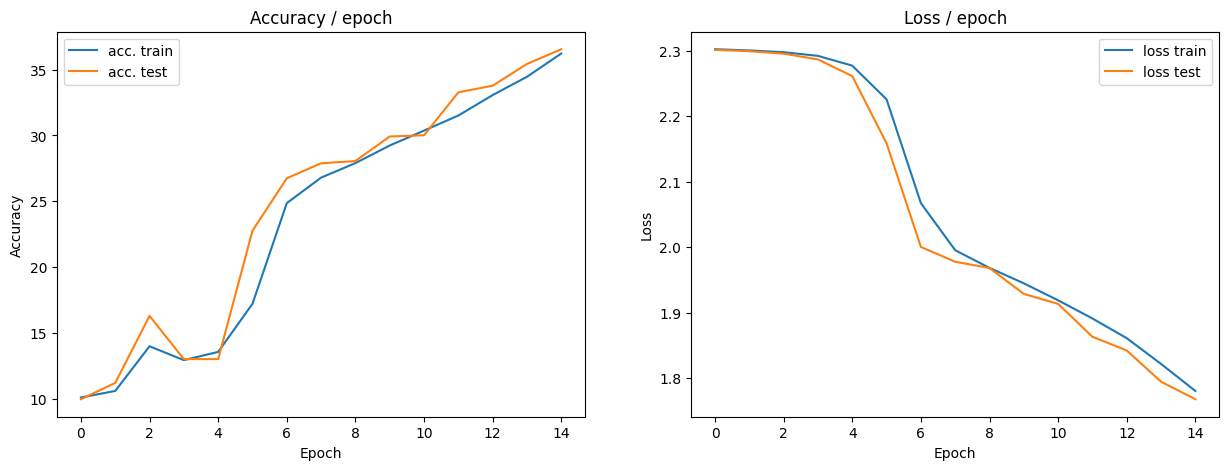

In [ ]:
plots_scheduler.plot("optim_variants")

In [ ]:
cuda = torch.cuda.is_available()
plots_schedulers = {}

schedulers = [
    lr_scheduler.ConstantLR,
    lr_scheduler.StepLR,
    lr_scheduler.ExponentialLR,
    lr_scheduler.PolynomialLR,
    lr_scheduler.LinearLR,
    lr_scheduler.CosineAnnealingLR,
]
lr_curves = {sch.__name__: [] for sch in schedulers}

for sch in schedulers:
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 0.1)

    if torch.cuda.is_available():  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    if sch.__name__ == "ExponentialLR":
        scheduler = sch(optimizer, gamma=0.95)
    elif sch.__name__ == "StepLR":
        scheduler = sch(optimizer, step_size=10)
    elif sch.__name__ == "CosineAnnealingLR":
        scheduler = sch(optimizer, T_max=EPOCHS)
    else:
        scheduler = sch(optimizer)

    train, test = get_dataset(BATCH_SIZE, cuda)
    plots_schedulers[sch.__name__] = AccLossPlot()

    for i in tqdm(range(EPOCHS)):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

        scheduler.step()
        plots_schedulers[sch.__name__].update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        lr_curves[sch.__name__] += scheduler.get_last_lr()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

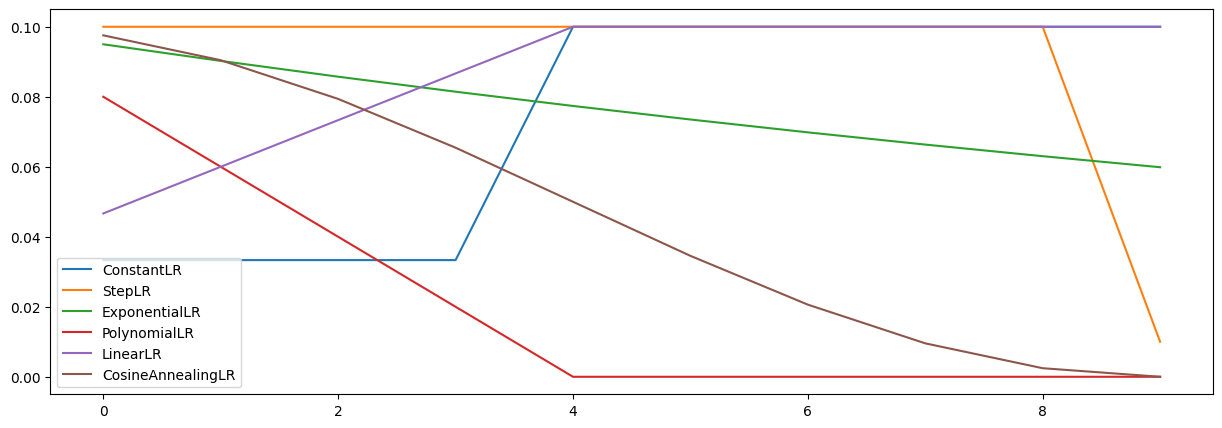

In [ ]:
plt.figure(figsize=(15, 5))
for sch in schedulers:
    plt.plot(lr_curves[sch.__name__], label=sch.__name__)
plt.legend()
plt.savefig("schedulers_comparison.pdf", dpi=100, bbox_inches="tight")

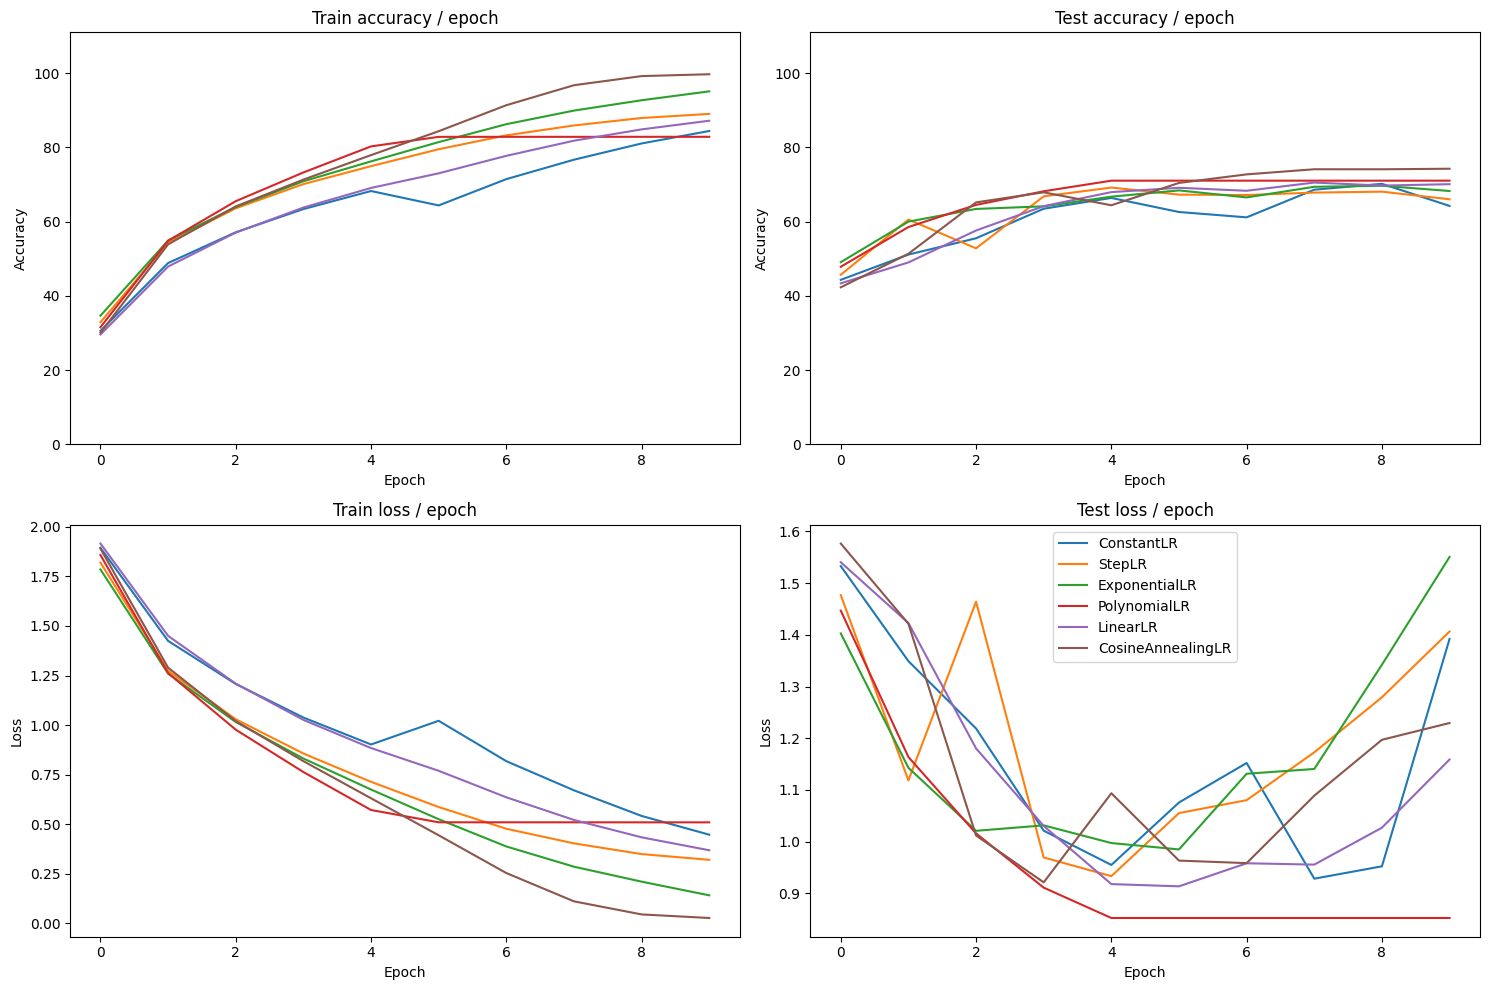

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

for sch, values in plots_schedulers.items():
    ax[0].plot(values.acc_train, label=f"{sch}")
    ax[1].plot(values.acc_test, label=f"{sch}")
    ax[2].plot(values.loss_train, label=f"{sch}")
    ax[3].plot(values.loss_test, label=f"{sch}")

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 111])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 111])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("schedulers_influence.pdf", dpi=100, bbox_inches="tight")
plt.show()

In [ ]:
plot_optimizers = {}

optimizers = [
    optim.SGD,
    optim.Adam,
    optim.AdamW,
    optim.Adagrad,
    optim.Adadelta,
    optim.RMSprop,
]

for opt in optimizers:
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    optimizer = opt(model.parameters(), LR)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    train, test = get_dataset(BATCH_SIZE, cuda)
    plot_optimizers[opt.__name__] = AccLossPlot()

    for i in tqdm(range(EPOCHS)):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

        scheduler.step()
        # Plots
        plot_optimizers[opt.__name__].update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## Batch Normalization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class with Dropout layers
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class with Dropout layers
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Smaller kernel size
            nn.BatchNorm2d(32),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Increased number of filters
            nn.BatchNorm2d(128),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Additional convolutional layer
            nn.BatchNorm2d(128),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # The correct flattened size is 128 * 2 * 2 = 512, based on the output from the conv layers.
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1000),  # Updated input size of the first linear layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Added Dropout before the final layer
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)  # Flatten the conv layer output
        output = self.classifier(output)
        return output




def get_dataset(batch_size, cuda=False):
    transform = transforms.Compose([
    transforms.ToTensor()])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)


    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        # print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Files already downloaded and verified
Files already downloaded and verified


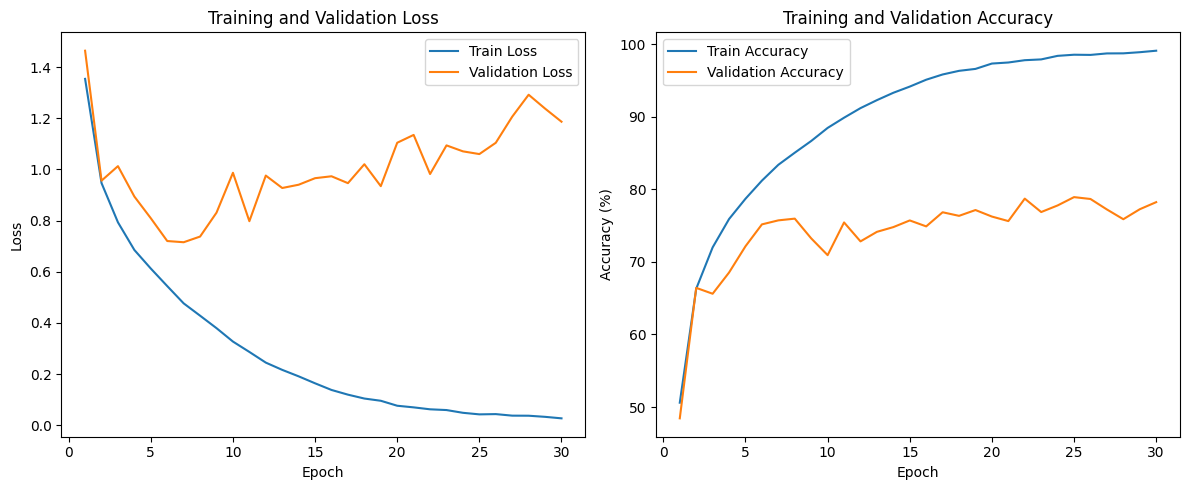

In [ ]:
main(batch_size=128, lr=0.005, epochs=30, cuda=torch.cuda.is_available())

# Best Combination

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class with Dropout layers
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


# Define the ConvNet class with Dropout layers
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Smaller kernel size
            nn.BatchNorm2d(32),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Increased number of filters
            nn.BatchNorm2d(128),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Additional convolutional layer
            nn.BatchNorm2d(128),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # The correct flattened size is 128 * 2 * 2 = 512, based on the output from the conv layers.
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1000),  # Updated input size of the first linear layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Added Dropout before the final layer
            nn.Linear(1000, 10)
        )

    def forward(self, input):
        bsize = input.size(0)
        output = self.features(input)
        output = output.view(bsize, -1)  # Flatten the conv layer output
        output = self.classifier(output)
        return output


# Normalization methods
def per_channel_standardization(image):
    mean = torch.tensor([0.491, 0.482, 0.447]).view(3, 1, 1)
    std = torch.tensor([0.202, 0.199, 0.201]).view(3, 1, 1)
    return (image - mean) / std

def zca_whitening(image, epsilon=1e-5):
    image = image.view(3, -1).numpy()
    sigma = np.cov(image, rowvar=True)
    U, S, _ = np.linalg.svd(sigma + epsilon * np.eye(sigma.shape[0]))
    ZCA_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S)), U.T))
    whitened = np.dot(ZCA_matrix, image)
    return torch.tensor(whitened).view(3, 32, 32)

def min_max_normalization(image, min_val=0, max_val=1):
    min_image = image.min()
    max_image = image.max()
    return (image - min_image) / (max_image - min_image) * (max_val - min_val) + min_val


def get_dataset(batch_size, cuda=False, method='standardization'):
    # Define transform functions based on the selected normalization method
    if method == 'standardization':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: per_channel_standardization(x))
        ])
    elif method == 'zca':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: zca_whitening(x))
        ])
    elif method == 'min_max':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: min_max_normalization(x))
        ])
    else:
        raise ValueError(f"Unknown method: {method}")

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    model.eval() if optimizer is None else model.train()

    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()

    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:
            input = input.cuda()
            target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)

    return avg_top1_acc.avg, avg_top5_acc.avg, avg_loss.avg


def main(batch_size=128, lr=0.1, epochs=5, cuda=False, method='standardization'):
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, test_loader = get_dataset(batch_size, cuda, method=method)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch_idx in range(epochs):
        print(f"=================\n=== EPOCH {epoch_idx + 1} ====\n=================\n")

        # Train phase
        train_acc, _, train_loss = epoch(train_loader, model, criterion, optimizer, cuda)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        val_acc, _, val_loss = epoch(test_loader, model, criterion, cuda=cuda)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Plotting the losses and accuracies
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


100%|██████████| 170M/170M [00:04<00:00, 40.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
=== EPOCH 1 ====

=== EPOCH 2 ====

=== EPOCH 3 ====

=== EPOCH 4 ====

=== EPOCH 5 ====

=== EPOCH 6 ====

=== EPOCH 7 ====

=== EPOCH 8 ====

=== EPOCH 9 ====

=== EPOCH 10 ====

=== EPOCH 11 ====

=== EPOCH 12 ====

=== EPOCH 13 ====

=== EPOCH 14 ====

=== EPOCH 15 ====

=== EPOCH 16 ====

=== EPOCH 17 ====

=== EPOCH 18 ====

=== EPOCH 19 ====

=== EPOCH 20 ====

=== EPOCH 21 ====

=== EPOCH 22 ====

=== EPOCH 23 ====

=== EPOCH 24 ====

=== EPOCH 25 ====

=== EPOCH 26 ====

=== EPOCH 27 ====

=== EPOCH 28 ====

=== EPOCH 29 ====

=== EPOCH 30 ====



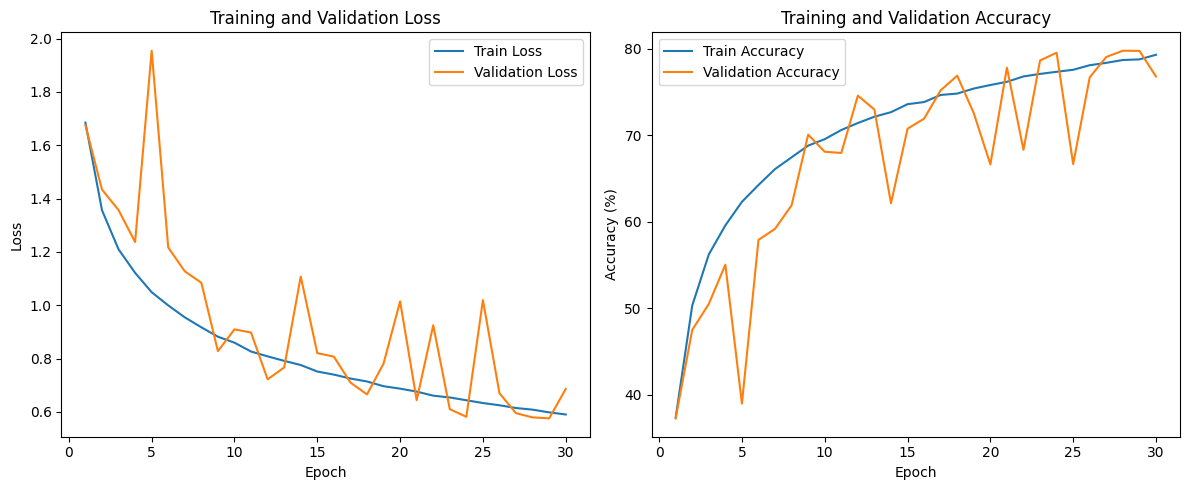

In [ ]:
main(batch_size=128, lr=0.005, epochs=30, cuda=torch.cuda.is_available(), method='min_max')